# Fundamentals of Machine Learning - Exercise 3
Dominique Cheray & Jacqueline Wagner
## Naive Bayes Classifier

In [5]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

In [2]:
digits = load_digits()
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

# filter data for 3 and 9
filter_mask = (target == 3) | (target == 9)
data = data[filter_mask]
images = images[filter_mask]
target = target[filter_mask]
# get averave image of three and nine, calculate difference and keept two most
# different pixel in the reduced data
threes = images[target == 3]
nines = images[target == 9]
threes_average = np.mean(threes, axis=0)
nines_average = np.mean(nines, axis=0)
difference = np.abs(np.subtract(threes_average, nines_average))
difference_flat = difference.flatten()
indices = difference_flat.argsort()[-2:][::-1]
print(indices)

# split data into test and training set
x_train, x_test, y_train, y_test = model_selection.train_test_split(data,
                                                                    target,
                                                                    test_size=0.33,
                                                                    random_state=0)
x_train_reduced = x_train[:, [18, 26]]
x_test_reduced = x_test[:, [18, 26]]


[26 18]


In [18]:
def fit_naive_bayes(features, labels, bincount=0):
    unique_labels = np.unique(labels)
    N = len(features)
    L = bincount
    histograms = []
    binning = []
    # if no bincount is given determine it according to freedman diaconis
    if bincount == 0:
        iqrs = stats.iqr(features, axis=0)
        delta_x = iqrs[:] * 2.0 / (N ** (1.0/3.0))
        delta_x[delta_x == 0] = np.max(features)
        nr_bins = np.ceil((np.max(features, axis=0) - np.min(features, axis=0)) / delta_x)
        L = int(np.mean(nr_bins))
    for label in unique_labels:
        cl = features[labels == label]
        # adapt delta_x to bincount (either given or determined by freedman diaconis)
        delta_x = ((np.max(cl, axis=0) - np.min(cl, axis=0)) / (L-1))
        delta_x[delta_x == 0] = np.max(cl)
        lower_bound = np.min(cl, axis=0)
        binshape = np.zeros((len(features[0]), 2))
        binshape[:, 0] = lower_bound
        binshape[:, 1] = delta_x
        binning.append(binshape)
        # assign a bin nr to every feature of every instance of this class
        bins = np.floor((cl - lower_bound)/delta_x).astype(int)
        hist = np.zeros((len(cl[0]), (L)))
        for i in range(len(cl[0])):
            # for every feature fill the bins of the histogram
            # with the probability for x in bin
            values, counts = np.unique(bins[:, i], return_counts=True)
            hist[i][values] = np.log(counts / (len(cl) * delta_x[i]))
        histograms.append(hist)
    histograms = np.asarray(histograms)
    binning = np.asarray(binning)
    return histograms, binning


hists64, binning64 = fit_naive_bayes(x_train, y_train, 8)

hists2, binning2 = fit_naive_bayes(x_train_reduced, y_train)

In [19]:
def predict_naive_bayes(test_features, histograms, binning):
    L = len(histograms[0][0]) - 1
    prediction = []
    for i in range(len(histograms)):
        bins = np.floor((test_features - binning[i, :, 0]) /binning[i, :, 1]).astype(int)
        bins[bins < 0] = 0
        bins[bins > L] = L
        probabilites = np.zeros(len(bins))
        # bins: samples x features
        # hist: classes x features x nr_bins
        # for every sample
        for j in range(len(bins)):
            sum = 0
            # for every feature
            for k in range(len(bins[i])):
                # sum probablites for the features of this sample under class i
                sum = sum + histograms[i][k][bins[j][k]]
            probabilites[j] = sum
        prediction.append(probabilites)
    prediction = np.asarray(prediction)
    return np.argmax(prediction, axis=0)

predicted_labels2 = predict_naive_bayes(x_test_reduced, hists2, binning2)
predicted_labels2[predicted_labels2 == 0] = 3
predicted_labels2[predicted_labels2 == 1] = 9

predicted_labels64 = predict_naive_bayes(x_test, hists64, binning64)
predicted_labels64[predicted_labels64 == 0] = 3
predicted_labels64[predicted_labels64 == 1] = 9

In [20]:
confusion2 = confusion_matrix(y_test, predicted_labels2)
confusion64 = confusion_matrix(y_test, predicted_labels64)
print(confusion2)
print(confusion64)

[[53  9]
 [ 5 53]]
[[57  5]
 [ 1 57]]


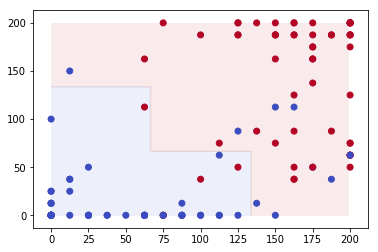

In [21]:
x_test_rescaled = x_test_reduced[:,:] * 200 / 16
x_train_rescaled = x_train_reduced[:,:] * 200 / 16
# train naive bayes on the image space
hists_scaled, binnings_scaled = fit_naive_bayes(x_train_rescaled, y_train)
xx, yy = np.meshgrid(np.arange(0, 200, 1),
np.arange(0, 200, 1))
z = predict_naive_bayes(np.c_[xx.ravel(), yy.ravel()], hists_scaled, binnings_scaled)
z = z.reshape(xx.shape)
plt.contourf(xx, yy, z, alpha=0.1, cmap=plt.cm.coolwarm)
plt.scatter(x_test_rescaled[:,0], x_test_rescaled[:,1], c=y_test, alpha=1, cmap=plt.cm.coolwarm)
plt.show()